In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import importlib as imp
import generator as gen
import binary_logistic_regression as logreg
import optimizer as opt
import data_visualization as viz
import time

In [8]:
imp.reload(gen)
imp.reload(viz)

<module 'data_visualization' from '/Users/remilepriol/Dropbox/intership2017/code/data_visualization.py'>

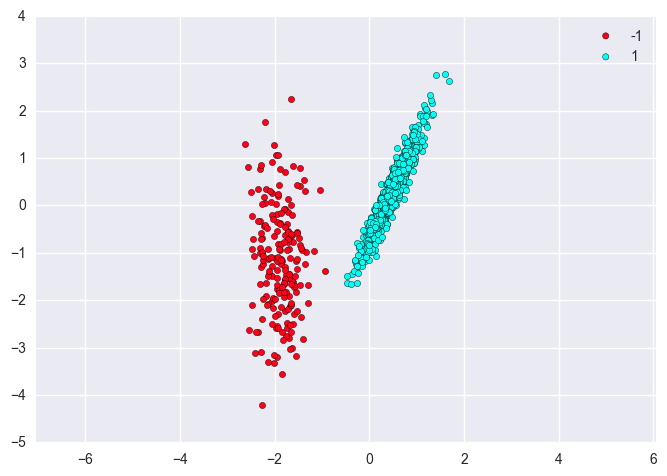

In [10]:
n = 1000
d = 2
bias_constant=1
x,y,mu,sig = gen.gengaussians(n,d,theta=.8,shift=1,randomcov=True)
x = gen.standardize(x)
# add 10000 at the end of the x to account for the bias.
# TODO how to make the gradient descent numerically stable for large values of the bias ? I have to drastically lower
# the step size, I guess.
x = np.concatenate((x,bias_constant*np.ones([n,1])),axis=1)
viz.plot_data(x,y)
pass

Logistic model : the conditional probability of observing y=1 knowing x is the sigmoid (logisitc function) of a linear function in x.

$$p(y|x;w,b)=\sigma(y(w^Tx+b))=\frac{1}{1+\exp(-y(w^Tx+b))}$$

To account for b transparently, we add 10,000 at the end of each vector x.

In [11]:
w = np.random.rand(d+1)
w[-1]=0
print(logreg.negloglikelihood(w,x,y))

0.543568872031


In [12]:
w0= np.random.randn(d+1)

In [13]:
step_size = .001 #"auto"
reg = 1/n
bias=True
precision = 1e-7
sgdparameters =  [logreg.negloglikelihood,logreg.stochastic_gradient,step_size,w0,x,y,reg,bias]

In [14]:
wsgd,objsgd,_ = opt.stochastic_gradient_descent(*sgdparameters)
wsgdu,objsgdu,_ = opt.stochastic_gradient_descent(*sgdparameters,average="uniform")
wsgda,objsgda,_ = opt.stochastic_gradient_descent(*sgdparameters,average="linear")

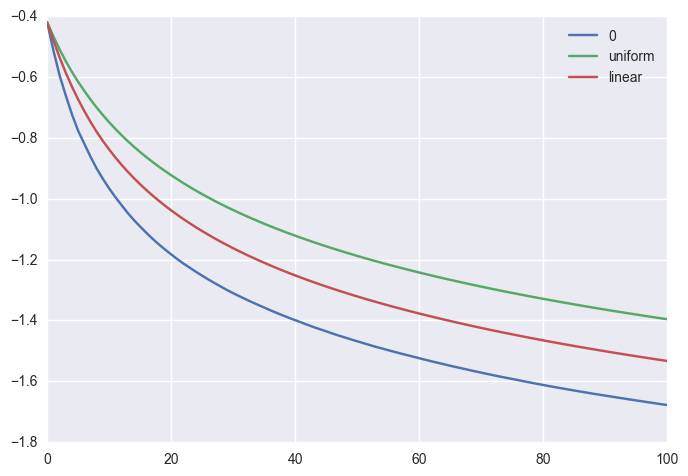

In [15]:
plt.plot(np.log10(objsgd),label='0')
plt.plot(np.log10(objsgdu),label='uniform')
plt.plot(np.log10(objsgda),label='linear')
plt.legend()

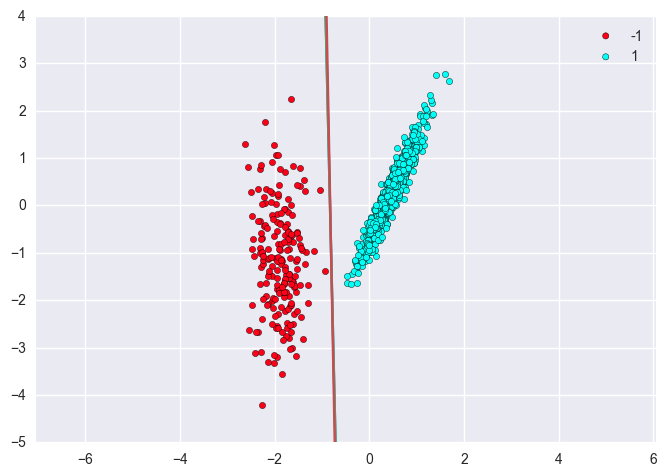

In [16]:
imp.reload(viz)
viz.plot_data(x,y)
viz.plot_discriminator(wsgd)
viz.plot_discriminator(wsgdu)
viz.plot_discriminator(wsgda)

With unequal distribution between the two gaussians and uniform sampling, the classifier totally favors the gaussian with more data points.

In [18]:
wsag,objsag,gradsag,wnorms_sag,time_sag = opt.saga(*sgdparameters,sag=True)
wsaga,objsaga,gradsaga,wnorms_saga,time_saga = opt.saga(*sgdparameters,sag=False)

In [19]:
print(len(objsag))
truesag = objsag+wnorms_sag
truesaga = objsaga+wnorms_saga

16


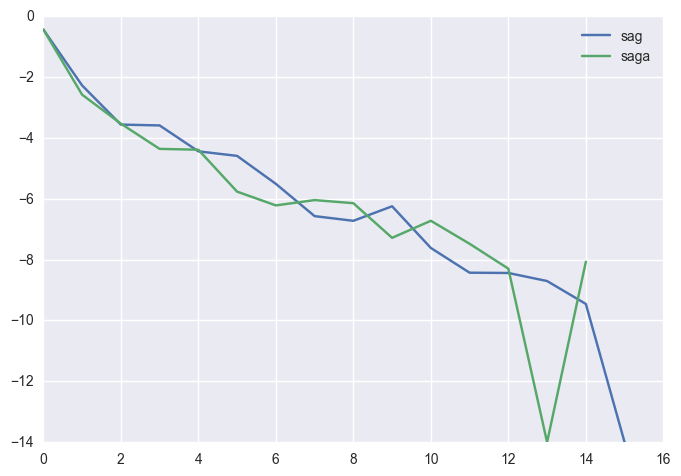

In [20]:
plt.plot(np.log10(np.maximum(precision**2,truesag-truesag[-1])),label='sag')
plt.plot(np.log10(np.maximum(precision**2,truesaga-truesag[-1])),label='saga')
plt.legend()

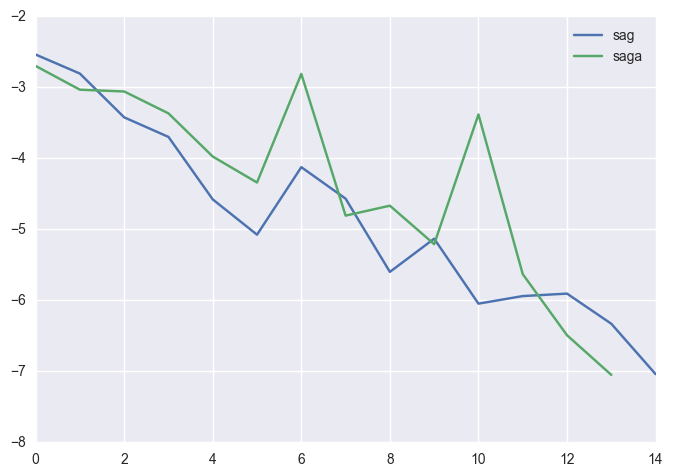

In [21]:
plt.plot(np.log10(gradsag),label='sag',alpha=1)
plt.plot(np.log10(gradsaga),label='saga',alpha=1)
plt.legend()

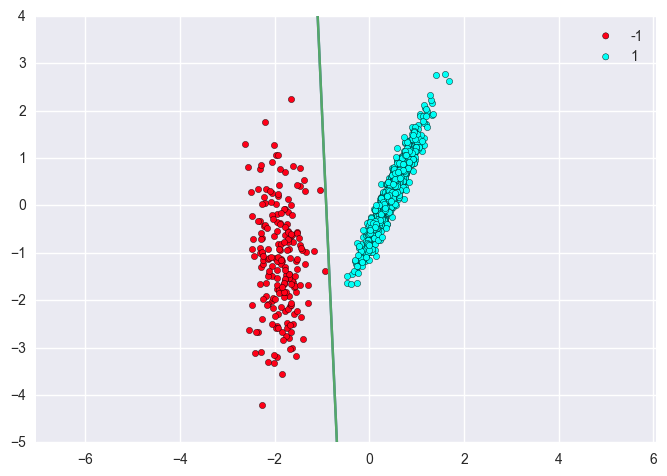

In [22]:
viz.plot_data(x,y)
viz.plot_discriminator(wsag)
viz.plot_discriminator(wsaga)

Halley's method is much more unstable than Newton's method as it is.

Formulas for the coefficients in the line search function.
$$a = \frac{\|x_i\|^2}{\lambda n}$$
$$b = \frac{1}{\lambda n} \sum_{j\neq i} \alpha_j y_i y_j \langle x_i, x_j \rangle = \langle y_i x_i, \frac{1}{\lambda n} \sum_{j\neq i} \alpha_j y_j x_j \rangle = \langle y_i x_i, w \rangle - \alpha_i \frac{\|x_i\|^2}{\lambda n}$$

In [23]:
alpha0 = np.random.rand(n)

In [25]:
wsdca,alpha,objsdca,time_sdca = opt.sdca(alpha0,x,y,reg,npass=100)

In [26]:
print(objsdca[-1])

[  1.75855114e-02   9.94807967e-03   4.51191025e-02  -1.22124533e-15]


/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


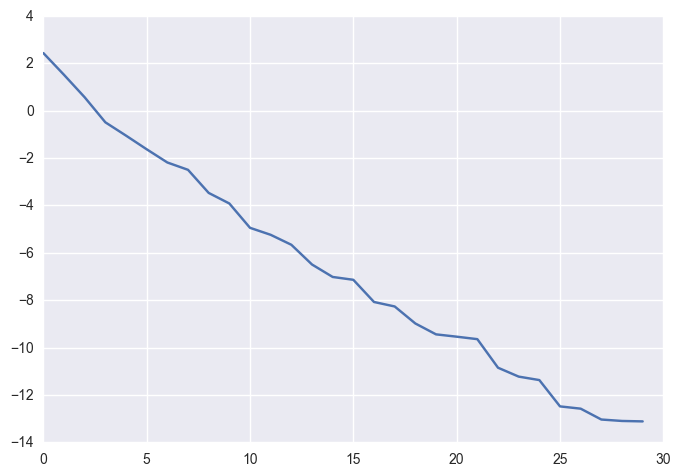

In [27]:
plt.plot(np.log10(objsdca[:,-1]))

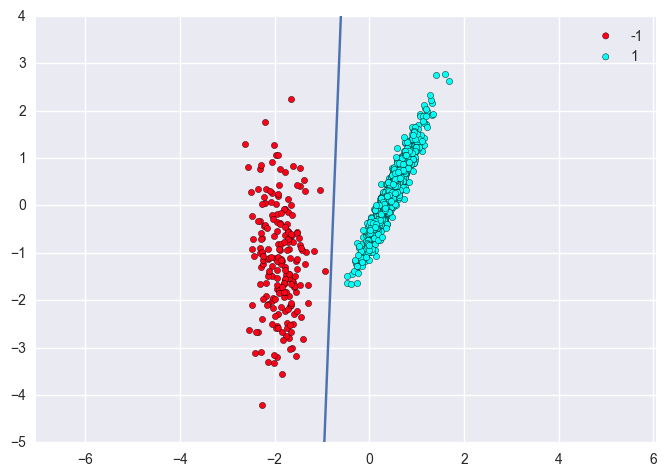

In [28]:
viz.plot_data(x,y)
viz.plot_discriminator(wsdca)

Problem : SDCA has to regularize the bias term. Otherwise there is an equlity constraint in the dual problem, and one has to move coordinates 2 by 2.

In [ ]:
plt.plot(alpha,'bo')

# Comparison of SGD, SAG and SDCA

### SYNTHETIC DATA

In [ ]:
n = 5000
d = 200
bias_constant=1
x,y,mu,sig = gen.gengaussians(n,d,theta=.8,shift=1,randomcov=True)
x = gen.standardize(x)
# add 10000 at the end of the x to account for the bias.
# TODO how to make the gradient descent numerically stable for large values of the bias ? I have to drastically lower
# the step size, I guess.
x = np.concatenate((x,bias_constant*np.ones([n,1])),axis=1)
viz.plot_data(x,y)
pass

In [ ]:
imp.reload(gen)
imp.reload(logreg)
imp.reload(opt)
pass

In [ ]:
alpha0 = np.random.rand(n)
w0 = logreg.dual_to_primal(alpha0,x,y,reg)
#alpha0=np.zeros(n)
#w0=np.zeros(d+1)

In [ ]:
parameters = {"objective":logreg.negloglikelihood,
             "gradient":logreg.stochastic_gradient,
             "step_size":0.01,
             "w0":w0,
             "x":x,
             "y":y,
             "reg":reg,
             "npass":100,
             "bias":False}

In [ ]:
wsag,objsag,gradsag,wnorm_sag,time_sag = opt.saga(**parameters,sag=True,uselinesearch=True,precision=1e-10,nonuniform=True)
truesag = objsag+wnorm_sag

In [ ]:
wsdca,alpha,objsdca,time_sdca = opt.sdca(alpha0,x,y,reg,npass=100)
truesdca = objsdca[:,0]+objsdca[:,1]

In [ ]:
minobj = min(np.amin(truesag),np.amin(truesdca))-1e-15
logobj_sag = np.log10(truesag-minobj)
logobj_sdca = np.log10(truesdca-minobj)
plt.figure(figsize=(10,4))
# Plot against the number of passes over the data.
plt.subplot(1,2,1)
#plt.plot(np.log10(truesgd-minobj),label='averaged sgd')
plt.plot(logobj_sag,label='nus sag')
plt.plot(logobj_sdca,label='sdca')
plt.legend(loc='best')
plt.ylabel("log10(score)")
plt.xlabel("npass")
# Plot against the time
plt.subplot(1,2,2)
plt.plot(time_sag,logobj_sag,label='nus sag')
plt.plot(time_sdca,logobj_sdca,label='sdca')
plt.legend(loc='best')
plt.xlabel("time (s)")
plt.suptitle('Primal scores of the logistic regression on the quantum dataset')
#plt.savefig('images/quantum.pdf')

### TRUE DATA

In [ ]:
quantum = np.genfromtxt('../data/data_kddcup04/phy_train.dat')

In [ ]:
quantum.shape

In [ ]:
quantum_y = quantum[:,1]
quantum_x = quantum[:,2:]
nq,dq = quantum_x.shape
print(nq,dq)

In [ ]:
# sparsity level of each feature.
# we will call sparse whatever is above 0.8 and dense whatever is below.
# I should look at the histograms if I want to get a real intuition of what is sparse and what is not.
non_zeros = np.sum(quantum_x!=0,axis=0)
plt.plot(non_zeros/nq,'r^')
pass

In [ ]:
bins=100
quantum_densities = np.zeros([dq,bins])
bin_edges = np.zeros([dq,bins+1])
for i in range(dq):
    quantum_densities[i],bin_edges[i]= np.histogram(quantum_x[:,i],bins,density=True)

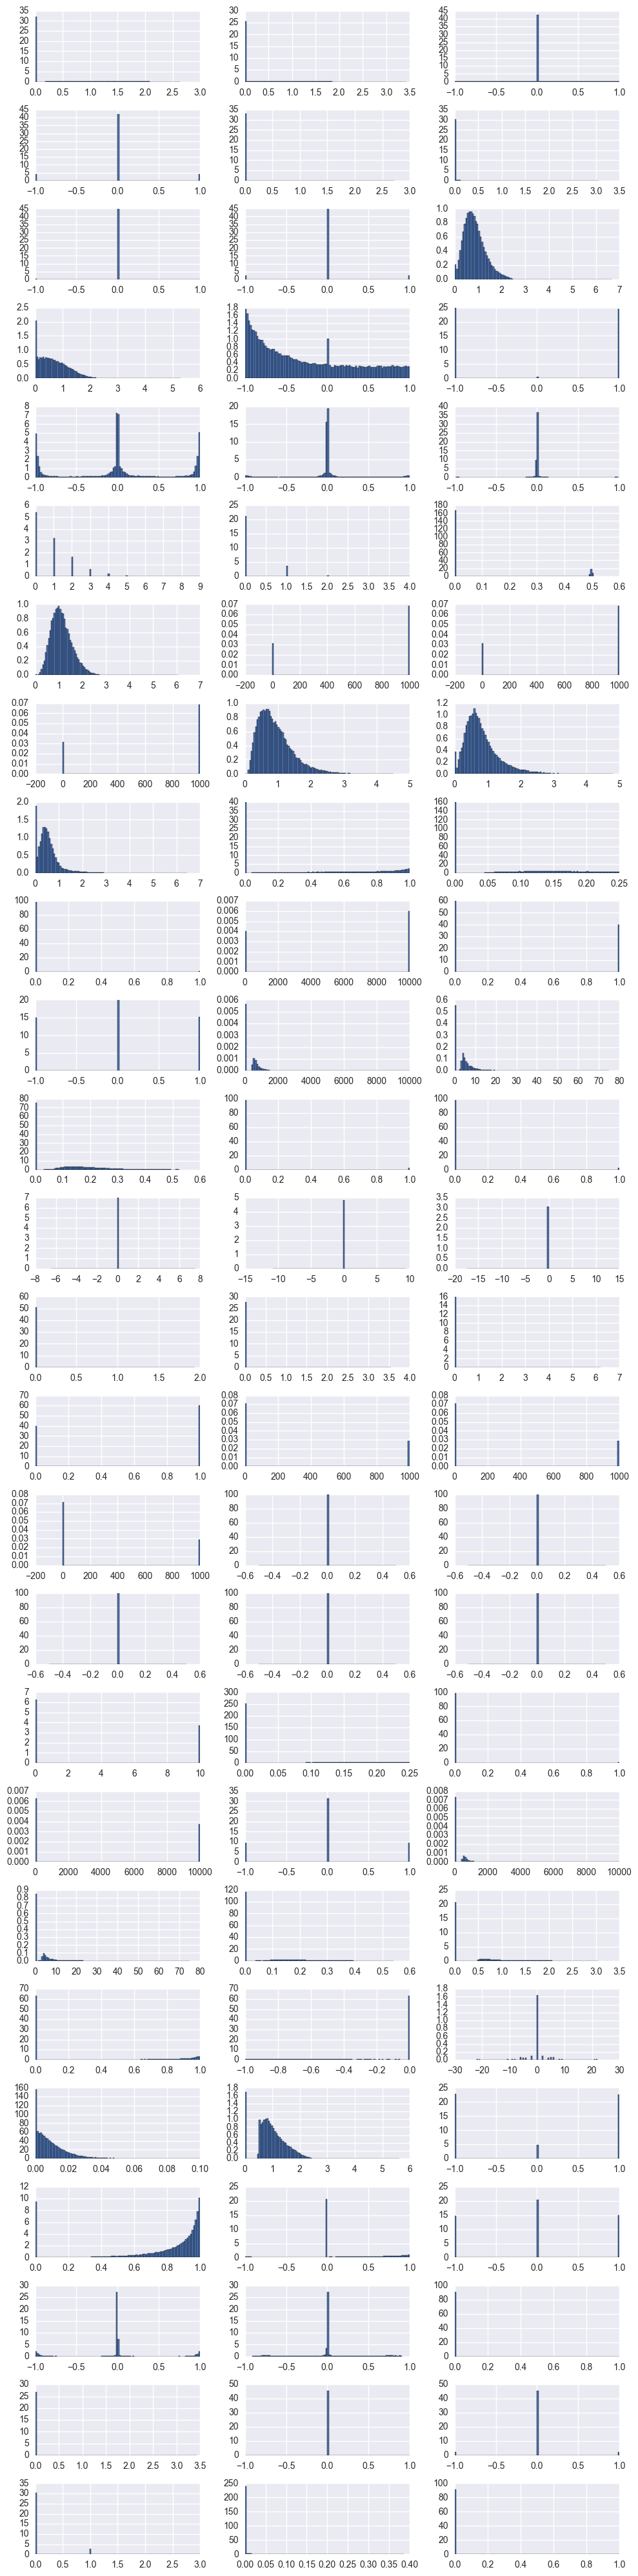

In [534]:
fig,axs = plt.subplots(nrows=26,ncols=3,figsize=(10,40))
axs = axs.flatten()
for i in range(dq):
    width = bin_edges[i,1]-bin_edges[i,0]
    axs[i].bar(left=bin_edges[i,:-1],height=quantum_densities[i],width=width)
plt.tight_layout()

In [540]:
alpha0 = np.random.rand(nq)
w0 = logreg.dual_to_primal(alpha0,quantum_x,quantum_y,reg)
parameters = {"objective":logreg.negloglikelihood,
             "gradient":logreg.stochastic_gradient,
             "step_size":0.01,
             "w0":w0,
             "x":quantum_x,
             "y":quantum_y,
             "reg":1/nq,
             "npass":100,
             "bias":False}

In [541]:
wsag,objsag,gradsag,wnorm_sag,time_sag = opt.saga(**parameters,sag=True,uselinesearch=True,precision=1e-4,nonuniform=True)
truesag = objsag+wnorm_sag

In [542]:
wsdca,alpha,objsdca,time_sdca = opt.sdca(alpha0,quantum_x,quantum_y,reg,npass=100,precision=1e-6)
truesdca = objsdca[:,0]+objsdca[:,1]

SAG : 5 min /
SDCA : 31 min

- This is all super slow. A way to increase the speed is sparse updates : some of the features are sparse as seen above. Will standardization of the dense features improve the speed?
- Also, why is sdca so much slower than sag. Are the line search really slow?
- Still, SDCA does converge linearly, at least at the beginning, until $10^{-7}$. Why does SAG plateau between 100 and 10? 

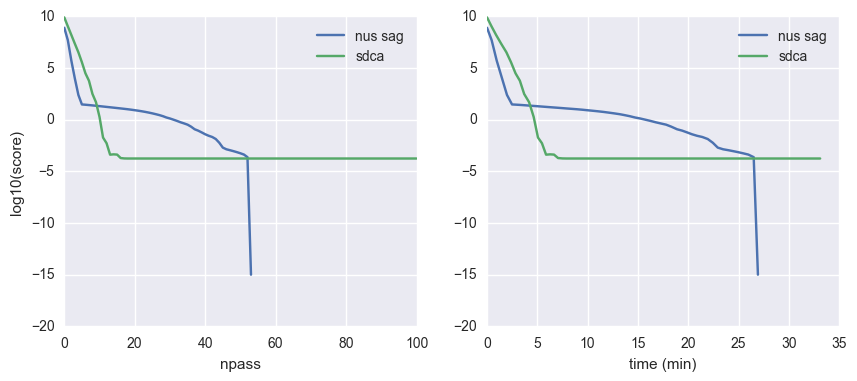

In [544]:
minobj = min(np.amin(truesag),np.amin(truesdca))-1e-15
logobj_sag = np.log10(truesag-minobj)
logobj_sdca = np.log10(truesdca-minobj)
plt.figure(figsize=(10,4))
# Plot against the number of passes over the data.
plt.subplot(1,2,1)
#plt.plot(np.log10(truesgd-minobj),label='averaged sgd')
plt.plot(logobj_sag,label='nus sag')
plt.plot(logobj_sdca,label='sdca')
plt.legend(loc='best')
plt.ylabel("log10(score)")
plt.xlabel("npass")
# Plot against the time
plt.subplot(1,2,2)
plt.plot(time_sag/60,logobj_sag,label='nus sag')
plt.plot(time_sdca/60,logobj_sdca,label='sdca')
plt.legend(loc='best')
plt.xlabel("time (min)")